In [1]:
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import *
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import load_model
import os
from art.attacks import FastGradientMethod
from art.classifiers import KerasClassifier
import matplotlib.pyplot as plt
from numpy import load
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.


## Data Preparation

In [2]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.1
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if True:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


## Training a Denoising Auto Encoder (DAE) with skip connections

In [3]:
def conv_block(x, filters, kernel_size, strides=2):
    x = tfmot.quantization.keras.quantize_annotate_layer(Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same'))(x)
    x = BatchNormalization()(x)
    x = tfmot.quantization.keras.quantize_annotate_layer(ReLU())(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
    x = BatchNormalization()(x)
    x = tfmot.quantization.keras.quantize_annotate_layer(ReLU())(x)
    return x

dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
conv_block1 = conv_block(dae_inputs, 32, 3)
conv_block2 = conv_block(conv_block1, 64, 3)
conv_block3 = conv_block(conv_block2, 128, 3)
conv_block4 = conv_block(conv_block3, 256, 3)
conv_block5 = conv_block(conv_block4, 256, 3, 1)

deconv_block1 = deconv_block(conv_block5, 256, 3)
merge1 = Concatenate()([deconv_block1, conv_block3])
deconv_block2 = deconv_block(merge1, 128, 3)
merge2 = Concatenate()([deconv_block2, conv_block2])
deconv_block3 = deconv_block(merge2, 64, 3)
merge3 = Concatenate()([deconv_block3, conv_block1])
deconv_block4 = deconv_block(merge3, 32, 3)

final_deconv = Conv2DTranspose(filters=3,
                   kernel_size=3,
                   padding='same')(deconv_block4)

dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)

dae = Model(inputs = dae_inputs, outputs = dae_outputs)
dae = tfmot.quantization.keras.quantize_apply(dae)
dae.compile(optimizer='adam', loss='mse')
dae.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

In [4]:
fgsmog = FastGradientMethod(ogcl, eps=0.1)
dae_train = fgsmog.generate(x_train)
dae_test = fgsmog.generate(x_test)

In [8]:
from numpy import load
dae_train = load('fgsmtrain(0.1).npy')
dae_test = load('fgsmtest(0.1).npy')
temp = load('fgsmtest(0.01).npy')

In [6]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(dae_train,
       x_train,
       validation_data=(dae_test, x_test),
       epochs=100,
       batch_size=256,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0474
Epoch 00001: val_loss improved from inf to 0.04195, saving model to best_model.h5
50000/50000 [==============================] - 34s 688us/sample - loss: 0.0474 - val_loss: 0.0419
Epoch 2/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0313
Epoch 00002: val_loss improved from 0.04195 to 0.03305, saving model to best_model.h5
50000/50000 [==============================] - 19s 388us/sample - loss: 0.0313 - val_loss: 0.0331
Epoch 3/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0307
Epoch 00003: val_loss improved from 0.03305 to 0.02998, saving model to best_model.h5
50000/50000 [==============================] - 19s 390us/sample - loss: 0.0307 - val_loss: 0.0300
Epoch 4/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0305
Epoch 00004: val_loss improved from 0.02998 to 0.02969, saving model to be

49920/50000 [============================>.] - ETA: 0s - loss: 0.0296
Epoch 00067: val_loss did not improve from 0.02896
50000/50000 [==============================] - 20s 400us/sample - loss: 0.0296 - val_loss: 0.0290
Epoch 68/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0296
Epoch 00068: val_loss did not improve from 0.02896
50000/50000 [==============================] - 20s 400us/sample - loss: 0.0296 - val_loss: 0.0290
Epoch 69/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0296
Epoch 00069: val_loss did not improve from 0.02896
50000/50000 [==============================] - 20s 401us/sample - loss: 0.0296 - val_loss: 0.0290
Epoch 70/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0296
Epoch 00070: val_loss did not improve from 0.02896
50000/50000 [==============================] - 20s 401us/sample - loss: 0.0296 - val_loss: 0.0290
Epoch 71/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.0296
Ep

In [ ]:
og = load_model('Resnet18-200epochs.h5')

In [9]:
test11 = dae.predict(dae_test)
test12 = dae.predict(x_test)
test13 = dae.predict(temp)

pred1 = og.predict(test11)
pred2 = og.predict(test12)
pred3 = og.predict(test13)

accuracy = np.sum(np.argmax(pred1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.01 test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on Original test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on denoised 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on denoised 0.01 test examples: 31.619999999999997%
Accuracy on Original test examples: 46.27%
Accuracy on denoised 0.1 test examples: 45.1%


In [16]:
new_x_train = dae.predict(x_train)
new_x_test = dae.predict(x_test)

## Defining Resnet18 

In [17]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = tfmot.quantization.keras.quantize_annotate_layer(Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4)))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = tfmot.quantization.keras.quantize_annotate_layer(Activation(activation))(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = tfmot.quantization.keras.quantize_annotate_layer(Activation(activation))(x)
        x = conv(x)
    return x

def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

depth = 20 
num_classes=10

num_filters_in = 16
num_res_blocks = int((depth - 2) / 9)

inputs = Input(shape=input_shape)
# v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
x = resnet_layer(inputs=inputs,
                 num_filters=num_filters_in,
                 conv_first=True)

# Instantiate the stack of residual units
for stage in range(3):
    for res_block in range(num_res_blocks):
        activation = 'relu'
        batch_normalization = True
        strides = 1
        if stage == 0:
            num_filters_out = num_filters_in * 4
            if res_block == 0:  # first layer and first stage
                activation = None
                batch_normalization = False
        else:
            num_filters_out = num_filters_in * 2
            if res_block == 0:  # first layer but not first stage
                strides = 2    # downsample

        # bottleneck residual unit
        y = resnet_layer(inputs=x,
                         num_filters=num_filters_in,
                         kernel_size=1,
                         strides=strides,
                         activation=activation,
                         batch_normalization=batch_normalization,
                         conv_first=False)
        y = resnet_layer(inputs=y,
                         num_filters=num_filters_in,
                         conv_first=False)
        y = resnet_layer(inputs=y,
                         num_filters=num_filters_out,
                         kernel_size=1,
                         conv_first=False)
        if res_block == 0:
            # linear projection residual shortcut connection to match
            # changed dims
            x = resnet_layer(inputs=x,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             strides=strides,
                             activation=None,
                             batch_normalization=False)
        x = keras.layers.add([x, y])

    num_filters_in = num_filters_out

# Add classifier on top.
# v2 has BN-ReLU before Pooling
x = BatchNormalization()(x)
x = tfmot.quantization.keras.quantize_annotate_layer(Activation('relu'))(x)
x = tfmot.quantization.keras.quantize_annotate_layer(AveragePooling2D(pool_size=8))(x)
y = tfmot.quantization.keras.quantize_annotate_layer(Flatten())(x)
outputs = tfmot.quantization.keras.quantize_annotate_layer(Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal'))(y)

# Instantiate model.
model = Model(inputs=inputs, outputs=outputs)
model = tfmot.quantization.keras.quantize_apply(model)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
quantize_layer_1 (QuantizeLayer (None, 32, 32, 3)    3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_conv2d_5 (QuantizeWrapper (None, 32, 32, 16)   483         quantize_layer_1[1][0]           
_____________________________________________________

__________________________________________________________________________________________________
quant_activation_13 (QuantizeWr (None, 8, 8, 128)    3           batch_normalization_22[1][0]     
__________________________________________________________________________________________________
quant_conv2d_21 (QuantizeWrappe (None, 8, 8, 128)    147843      quant_activation_13[0][0]        
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 8, 8, 128)    512         quant_conv2d_21[0][0]            
__________________________________________________________________________________________________
quant_activation_14 (QuantizeWr (None, 8, 8, 128)    3           batch_normalization_23[1][0]     
__________________________________________________________________________________________________
quant_conv2d_23 (QuantizeWrappe (None, 8, 8, 256)    33539       add_3[1][0]                      
__________

## Composing DAE and Quantized Resnet18 into single model

In [20]:
combine = Model(inputs = dae.inputs, outputs = model((dae.outputs)))
combine.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dae_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 32, 32, 3)    3           dae_input[0][0]                  
__________________________________________________________________________________________________
quant_conv2d (QuantizeWrapper)  (None, 16, 16, 32)   963         quantize_layer[1][0]             
___________________________________________________________________________

## Train

In [18]:
# Training parameters
batch_size = 256  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = False
num_classes = 10

subtract_pixel_mean = True

version = 2

model_type = 'ResNet%dv%d' % (depth, version)

print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(new_x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(new_x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    combine.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

ResNet20v2
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Learning rate:  0.001
Epoch 1/50
50000/50000 [==============================] - 90s 2ms/sample - loss: 2.0618 - accuracy: 0.3988 - val_loss: 3.2298 - val_accuracy: 0.1346
Learning rate:  0.001
Epoch 2/50
50000/50000 [==============================] - 74s 1ms/sample - loss: 1.7273 - accuracy: 0.5055 - val_loss: 2.2154 - val_accuracy: 0.3448
Learning rate:  0.001
Epoch 3/50
50000/50000 [==============================] - 75s 1ms/sample - loss: 1.5431 - accuracy: 0.5652 - val_loss: 1.6828 - val_accuracy: 0.5139
Learning rate:  0.001
Epoch 4/50
50000/50000 [==============================] - 75s 2ms/sample - loss: 1.4135 - accuracy: 0.6083 - val_loss: 2.1530 - val_accuracy: 0.4429
Learning rate:  0.001
Epoch 5/50
50000/50000 [==============================] - 76s 2ms/sample - loss: 1.3074 - accuracy: 0.6401 - val_loss: 1.6385 - val_accuracy: 0.5508
Learning rate:  0.001
Epoch 6/50
50000/50000 [=========

Learning rate:  0.001
Epoch 25/50
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5290 - accuracy: 0.9211 - val_loss: 10.2741 - val_accuracy: 0.2132
Learning rate:  0.001
Epoch 26/50
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5101 - accuracy: 0.9292 - val_loss: 15.9616 - val_accuracy: 0.2640
Learning rate:  0.001
Epoch 27/50
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5049 - accuracy: 0.9308 - val_loss: 18.1712 - val_accuracy: 0.2494
Learning rate:  0.001
Epoch 28/50
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5091 - accuracy: 0.9284 - val_loss: 21.1761 - val_accuracy: 0.1255
Learning rate:  0.001
Epoch 29/50
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5011 - accuracy: 0.9332 - val_loss: 14.5744 - val_accuracy: 0.3173
Learning rate:  0.001
Epoch 30/50
50000/50000 [==============================] - 80s 2ms/sample - loss: 0.5000 - accuracy: 0.9334 - val

In [34]:
combine.save('combine-adv-train.h5')

In [39]:
OP = KerasClassifier(combine, clip_values=None, use_logits=False)
fgsm1 = FastGradientMethod(OP, eps=0.03)
fgsm2 = FastGradientMethod(OP, eps=0.05)
fgsm3 = FastGradientMethod(OP, eps=0.07)
fgsm4 = FastGradientMethod(OP, eps=0.1)
attack = fgsm1.generate(x_test)
attack1 = fgsm2.generate(x_test)
attack2 = fgsm3.generate(x_test)
attack3 = fgsm4.generate(x_test)

In [ ]:
from numpy import asarray
from numpy import save
save('combine-adv(0.03).npy', attack)
save('combine-adv(0.05).npy', attack1)
save('combine-adv(0.07).npy', attack2)
save('combine-adv(0.1).npy', attack3)

In [40]:
pred = OP.predict(x_test)
accuracy = np.sum(np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on OG test examples: {}%".format(accuracy * 100))

pred = OP.predict(attack)
accuracy = np.sum(np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on 0.03 test examples: {}%".format(accuracy * 100))

pred = OP.predict(attack1)
accuracy = np.sum(np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on 0.05 test examples: {}%".format(accuracy * 100))

pred = OP.predict(attack2)
accuracy = np.sum(np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on 0.07 test examples: {}%".format(accuracy * 100))

pred = OP.predict(attack3)
accuracy = np.sum(np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on OG test examples: 65.48%
Accuracy on 0.03 test examples: 21.19%
Accuracy on 0.05 test examples: 18.8%
Accuracy on 0.07 test examples: 17.49%
Accuracy on 0.1 test examples: 16.56%


## Data Visualization

### Test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


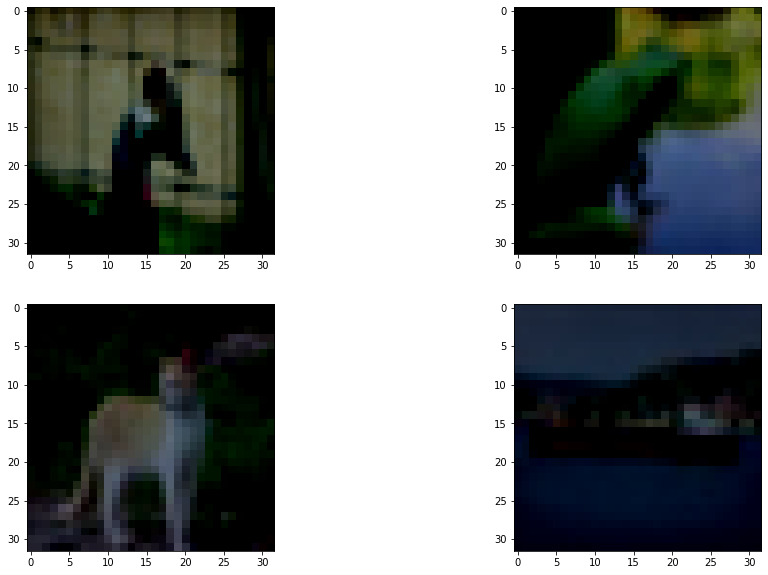

In [45]:
import datetime as dt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16,10))

for i in range(2):
    for j in range(2):
        axes[i, j].imshow(x_test[np.random.randint(10000, size=1)[0]][:,:,:])

### Clean data prediction

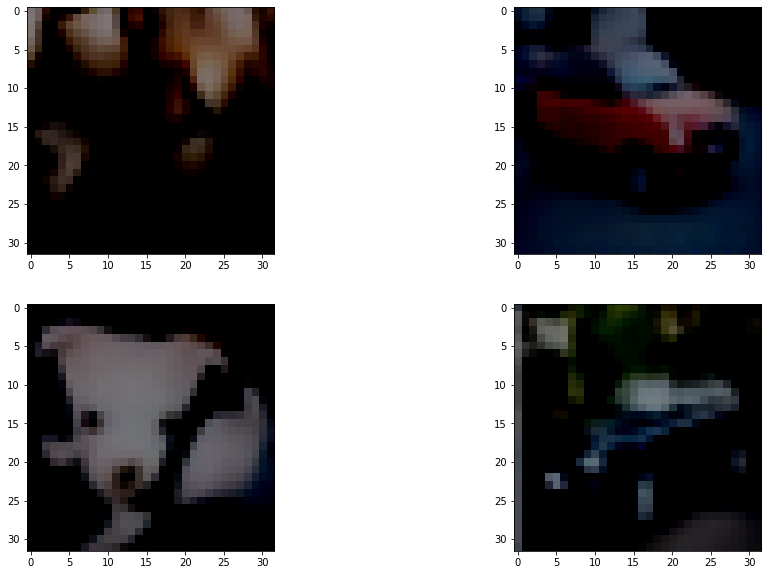

In [46]:
temp1 = m1.predict(x_test)
import datetime as dt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16,10))

for i in range(2):
    for j in range(2):
        axes[i, j].imshow(temp1[np.random.randint(10000, size=1)[0]][:,:,:])

### Adversarial samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


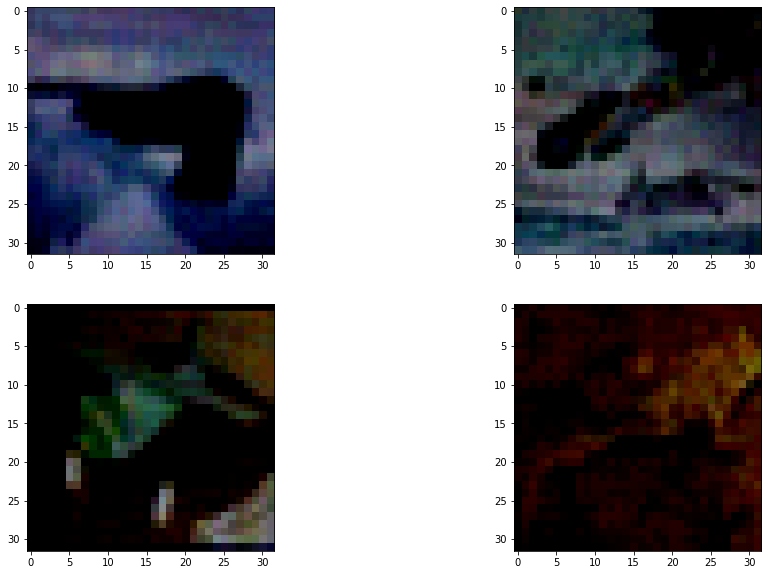

In [48]:
import datetime as dt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16,10))

for i in range(2):
    for j in range(2):
        axes[i, j].imshow(attack[np.random.randint(10000, size=1)[0]][:,:,:])

### Prediction on Adversarial Samples

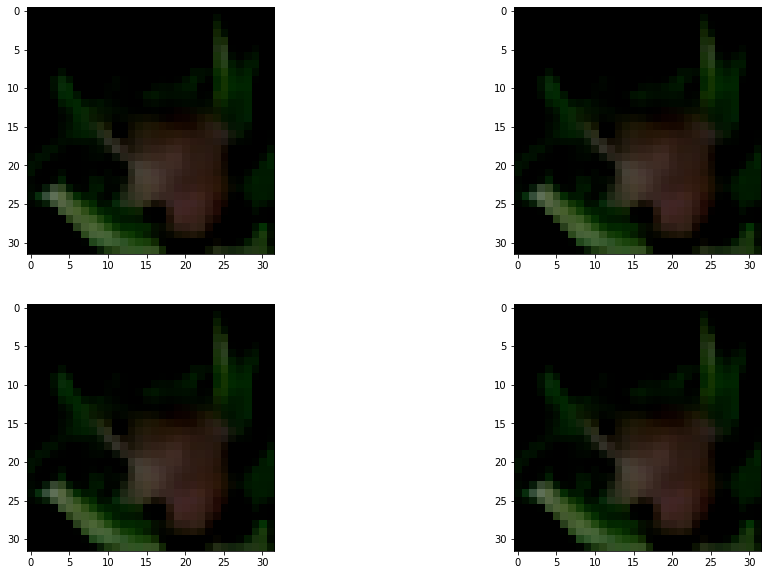

In [49]:
temp1 = m1.predict(attack)
import datetime as dt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16,10))

for i in range(2):
    for j in range(2):
        axes[i, j].imshow(temp1[[4][0]][:,:,:])